# Kindle Book Recommender System

### Imports

In [1]:
#!pip install texthero
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
df_meta = pd.read_csv('C:\\Users\\danie\\Desktop\\meta_use.csv')
df_meta.drop(columns = 'Unnamed: 0', inplace=True)
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478025 entries, 0 to 478024
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  478025 non-null  object
 1   title     476229 non-null  object
 2   brand     477393 non-null  object
 3   details   478025 non-null  object
 4   asin      478025 non-null  object
dtypes: object(5)
memory usage: 18.2+ MB


In [3]:
df_meta.head()

,category,title,brand,details,asin
0,"['Kindle Store', 'Kindle eBooks', 'Science Fic...",NaN,Arthur K. Barnes,"{'File Size:': '295 KB', 'Print Length:': '113...",B000FA5KKA
1,"['Kindle Store', 'Kindle eBooks', 'Biographies...",NaN,Jean Marie Stine,"{'File Size:': '262 KB', 'Print Length:': '103...",B000FA5KJQ
2,"['Kindle Store', 'Kindle eBooks', 'Science Fic...",NaN,Arthur K. Barnes,"{'File Size:': '251 KB', 'Print Length:': '116...",B000FA5NSO
3,"['Kindle Store', 'Kindle eBooks', 'Business & ...",NaN,Visit Amazon's Ethan M. Rasiel Page,"{'File Size:': '953 KB', 'Print Length:': '187...",B000FA5KX2
4,"['Kindle Store', 'Kindle eBooks', 'Business & ...",NaN,John Hayden,"{'File Size:': '627 KB', 'Print Length:': '240...",B000FA5M3U


In [4]:
df_meta.isna().sum()

category       0
title       1796
brand        632
details        0
asin           0
dtype: int64

In [5]:
df_meta.dropna(inplace=True)

In [6]:
asin_list = df_meta['asin'].tolist()

In [7]:
df_meta['category'].value_counts()

['Kindle Store', 'Kindle eBooks', 'Literature & Fiction']              147980
['Kindle Store', 'Kindle eBooks', 'Religion & Spirituality']            48422
['Kindle Store', 'Kindle eBooks', 'Romance']                            34237
['Kindle Store', 'Kindle eBooks', 'Science Fiction & Fantasy']          29180
['Kindle Store', 'Kindle eBooks', "Children's eBooks"]                  27289
['Kindle Store', 'Kindle eBooks', 'Business & Money']                   24217
['Kindle Store', 'Kindle eBooks', 'Health, Fitness & Dieting']          18679
['Kindle Store', 'Kindle eBooks', 'Mystery, Thriller & Suspense']       14859
['Kindle Store', 'Kindle eBooks', 'History']                            12786
['Kindle Store', 'Kindle eBooks', 'Biographies & Memoirs']              11532
['Kindle Store', 'Kindle eBooks', 'Cookbooks, Food & Wine']             10730
['Kindle Store', 'Kindle eBooks', 'Teen & Young Adult']                  8708
['Kindle Store', 'Kindle eBooks', 'Education & Teaching']       

In [8]:
df_meta['category'] = df_meta['category'].apply(eval)

In [9]:
def getLastValue(aList):
    return aList[-1]

In [10]:
df_meta['genre'] = df_meta['category'].apply(getLastValue)
df_meta.drop(columns=['category'], inplace=True)

In [11]:
df_meta['details'] = df_meta['details'].apply(eval)

In [12]:
details = list(df_meta['details'])

In [13]:
details

[{'File Size:': '298 KB',
  'Print Length:': '168 pages',
  'Simultaneous Device Usage:': 'Unlimited',
  'Publisher:': 'Outskirts Press (April 16, 2007)',
  'Publication Date:': 'April 16, 2007',
  'Language:': 'English',
  'ASIN:': 'B00128EFK0',
  'Word Wise:': 'Enabled',
  'Lending:': 'Enabled'},
 {'File Size:': '525 KB',
  'Print Length:': '17 pages',
  'Publisher:': 'Opera Journeys Publishing (January 4, 2008)',
  'Publication Date:': 'January 4, 2008',
  'Language:': 'English',
  'ASIN:': 'B00129LKMK',
  'Word Wise:': 'Not Enabled',
  'Lending:': 'Enabled'},
 {'File Size:': '1066 KB',
  'Print Length:': '207 pages',
  'Page Numbers Source ISBN:': '1430305630',
  'Simultaneous Device Usage:': 'Unlimited',
  'Publisher:': 'Lulu.com; 4th edition (October 15, 2007)',
  'Publication Date:': 'October 15, 2007',
  'Language:': 'English',
  'ASIN:': 'B0012AXRXO',
  'Word Wise:': 'Enabled',
  'Lending:': 'Enabled'},
 {'File Size:': '563 KB',
  'Print Length:': '208 pages',
  'Publication D

In [14]:
print_length = [d.get('Print Length:') for d in df_meta['details']]

In [15]:
df_meta['print_length'] = print_length

In [16]:
#df_meta['print_length'].astype(str)

In [17]:
df_meta['print_length'] = df_meta['print_length'].str.extract('(\d+)', expand=False)

In [18]:
df_meta['print_length'] = df_meta['print_length'].astype(float)

In [19]:
word_wise = [d.get('Word Wise:') for d in df_meta['details']]
df_meta['word_wise'] = word_wise

In [20]:
lending = [d.get('Lending:') for d in df_meta['details']]
df_meta['lending'] = lending

In [21]:
bool_dict = {'Enabled': 1, 'Not Enabled': 0}
df_meta['word_wise'] = df_meta['word_wise'].map(bool_dict)
df_meta['lending'] = df_meta['lending'].map(bool_dict)

In [22]:
df_meta_dummy = pd.get_dummies(df_meta, columns=['genre'])
df_meta_dummy.to_csv('Data/meta_dummy.csv')

In [23]:
df_meta.head()

,title,brand,details,asin,genre,print_length,word_wise,lending
1003,Approaching the Holy-A Season in God&#39;s Hou...,Dennis G. Crump,"{'File Size:': '298 KB', 'Print Length:': '168...",B00128EFK0,Religion & Spirituality,168.0,1,1
1010,Bellini&#39;s I PURITANI Opera Journeys Mini ...,Burton D. Fisher,"{'File Size:': '525 KB', 'Print Length:': '17 ...",B00129LKMK,Arts & Photography,17.0,0,1
1013,Snowman - Kindle edition,Visit Amazon's Dave Saari Page,"{'File Size:': '1066 KB', 'Print Length:': '20...",B0012AXRXO,"Mystery, Thriller & Suspense",207.0,1,1
1014,Crumbs and Crutons - Kindle edition,Visit Amazon's David Greer Page,"{'File Size:': '563 KB', 'Print Length:': '208...",B0012BKPEW,Literature & Fiction,208.0,1,1
1017,"Fast Track to Victory, A Christian Guidebook -...",Visit Amazon's Cheryl Rogers Page,"{'File Size:': '384 KB', 'Print Length:': '85 ...",B0012BS7UQ,Religion & Spirituality,85.0,1,1


In [24]:
df_meta.to_csv('Data/meta.csv')

In [25]:
df_rev = pd.read_csv('C:\\Users\\danie\\Desktop\\rev_use.csv')
df_rev.drop(columns=['Unnamed: 0'], inplace=True)
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398711 entries, 0 to 1398710
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   overall     1398711 non-null  int64 
 1   reviewTime  1398711 non-null  object
 2   reviewerID  1398711 non-null  object
 3   asin        1398711 non-null  object
 4   reviewText  1398705 non-null  object
 5   summary     1398710 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.0+ MB


In [26]:
df_rev.head()

,overall,reviewTime,reviewerID,asin,reviewText,summary
0,4,"07 3, 2014",A2LSKD2H9U8N0J,B000FA5KK0,"pretty good story, a little exaggerated, but I...",pretty good story
1,5,"05 26, 2014",A2QP13XTJND1QS,B000FA5KK0,"If you've read other max brand westerns, you k...",A very good book
2,5,"09 16, 2016",A8WQ7MAG3HFOZ,B000FA5KK0,"Love Max, always a fun twist",Five Stars
3,5,"03 3, 2016",A1E0MODSRYP7O,B000FA5KK0,"As usual for him, a good book",a good
4,5,"09 10, 2015",AYUTCGVSM1H7T,B000FA5KK0,MB is one of the original western writers and ...,A Western


In [27]:
df_rev = df_rev[df_rev['asin'].isin(asin_list)]

In [28]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395197 entries, 1389 to 1398710
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   overall     1395197 non-null  int64 
 1   reviewTime  1395197 non-null  object
 2   reviewerID  1395197 non-null  object
 3   asin        1395197 non-null  object
 4   reviewText  1395191 non-null  object
 5   summary     1395196 non-null  object
dtypes: int64(1), object(5)
memory usage: 74.5+ MB


In [29]:
df_rev.isna().sum()

overall       0
reviewTime    0
reviewerID    0
asin          0
reviewText    6
summary       1
dtype: int64

In [30]:
df_rev.dropna(inplace=True)

In [31]:
df_rev['reviewerID'].value_counts()

A3IQ0P3M39IY8U    716
A2UNMDJYXPEQZ3    716
A37LY77Q2YPJVL    652
A26GE9ZG68SKIQ    618
A2VXSQHJWZAQGY    613
                 ... 
A33K1NI7RNBOXC      1
ATQHH64HSWACX       1
A3LUQHKE8PJIZA      1
A27UILBR7S2VBG      1
A1FMKFE4BKRZ8X      1
Name: reviewerID, Length: 131022, dtype: int64

In [32]:
df_rev5 = df_rev[df_rev['reviewerID'].map(df_rev['reviewerID'].value_counts()) > 4]

In [33]:
df_rev5['reviewerID'].value_counts()

A3IQ0P3M39IY8U    716
A2UNMDJYXPEQZ3    716
A37LY77Q2YPJVL    652
A26GE9ZG68SKIQ    618
A2VXSQHJWZAQGY    613
                 ... 
A25ESJWHUN6JJU      5
A2S9TFI4MDIYIJ      5
A1ZECO8TKZ1KHP      5
A2HOVAXJ0TI5QE      5
A13ERVYVBZN1W6      5
Name: reviewerID, Length: 97588, dtype: int64

In [34]:
df_rev5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302158 entries, 1389 to 1398709
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   overall     1302158 non-null  int64 
 1   reviewTime  1302158 non-null  object
 2   reviewerID  1302158 non-null  object
 3   asin        1302158 non-null  object
 4   reviewText  1302158 non-null  object
 5   summary     1302158 non-null  object
dtypes: int64(1), object(5)
memory usage: 69.5+ MB


<AxesSubplot:>

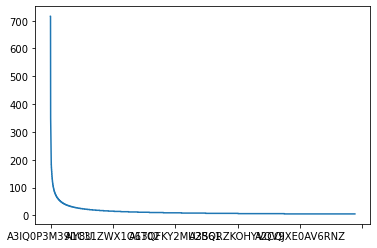

In [35]:
reviewers = df_rev5['reviewerID'].value_counts()
reviewers.plot()

In [36]:
df_rev5.to_csv('Data/df_rev5.csv')

In [37]:
popular = df_rev5.groupby(by = 'asin').count()
popular = popular.sort_values(by = 'overall', ascending=False)

In [38]:
popular.head()

,overall,reviewTime,reviewerID,reviewText,summary
asin,,,,,
B00YN6XHMU,1690,1690,1690,1690,1690
B00ESJ3S94,1012,1012,1012,1012,1012
B00C2WDD5I,760,760,760,760,760
B00IJYII4E,717,717,717,717,717
B004KKY782,623,623,623,623,623


In [39]:
df_most = df_rev5.loc[df_rev5['reviewerID'] == 'A3IQ0P3M39IY8U']
df_most['overall'].value_counts()

5    292
4    234
3    140
2     42
1      8
Name: overall, dtype: int64

In [40]:
df_2most = df_rev5.loc[df_rev5['reviewerID'] == 'A2UNMDJYXPEQZ3']
df_2most['overall'].value_counts()

5    265
4    193
3    157
2     76
1     25
Name: overall, dtype: int64

In [41]:
df_3most = df_rev5.loc[df_rev5['reviewerID'] == 'A37LY77Q2YPJVL']
df_3most['overall'].value_counts()

5    517
4    135
Name: overall, dtype: int64

In [42]:
df_4most = df_rev5.loc[df_rev5['reviewerID'] == 'A26GE9ZG68SKIQ']
df_4most['overall'].value_counts()

4    535
5     57
3     25
2      1
Name: overall, dtype: int64

In [43]:
df_5most = df_rev5.loc[df_rev5['reviewerID'] == 'A2VXSQHJWZAQGY']
df_5most['overall'].value_counts()

3    248
4    236
2    104
5     15
1     10
Name: overall, dtype: int64

In [44]:
#df_rev5['reviewText'].astype(str)

In [45]:
df_books_rev = df_rev5.groupby(['asin'], as_index = False).agg({'reviewText': ' '.join})
df_books_rev.to_csv('Data/df_books_rev.csv')

In [46]:
df_books_rev.head()

,asin,reviewText
0,B0012GTZCK,Not what I was expecting. I was looking for a ...
1,B0012LHGJ4,IT WAS DONE AS A FILM IN THE 1950-60s. VERY P...
2,B0012RMVH0,Needs pictures Excellent book. This is somethi...
3,B0012TAD1O,She always delivers with an exciting storyline...
4,B0012U0NKE,"<a data-hook=""product-link-linked"" class=""a-li..."


In [47]:
df_reviewers_rev = df_rev5.groupby(['reviewerID'], as_index = False).agg({'reviewText': ' '.join})
df_reviewers_rev.to_csv('Data/df_reviewers_rev.csv')

In [48]:
df_reviewers_rev.head()

,reviewerID,reviewText
0,A00463782V7TKAP9EMNL,College roommates find love for each other at ...
1,A0092581WFYQNV4KMUZ3,I guess the book was ok it just wasn't what I ...
2,A0099735VDZ3HDCAAYKL,I really hated that this was the last story it...
3,A01423305PUDQS2VV7QX,I really enjoyed this book. Lots of turns & su...
4,A01433701FZ0LF5G2RUL,I can't read anything about children especiall...


In [49]:
df_books_sum = df_rev5.groupby(['asin'], as_index = False).agg({'summary': ' '.join})
df_books_sum.to_csv('Data/df_books_sum.csv')

In [50]:
df_books_sum.head()

,asin,summary
0,B0012GTZCK,Not what I anticipated A must read
1,B0012LHGJ4,MOVIE MATERIAL MOVIE MATERIAL
2,B0012RMVH0,One Star Excellent book. This is something I h...
3,B0012TAD1O,Another great story from Kallysten! Another gr...
4,B0012U0NKE,Good read...


In [51]:
df_reviewers_sum = df_rev5.groupby(['reviewerID'], as_index = False).agg({'summary': ' '.join})
df_reviewers_sum.to_csv('Data/df_reviewers_sum.csv')

In [52]:
df_reviewers_sum.head()

,reviewerID,summary
0,A00463782V7TKAP9EMNL,Loved the Roommates Simply Wonderful iIs this ...
1,A0092581WFYQNV4KMUZ3,Connections Delilah Diary #3 glass Wanting mor...
2,A0099735VDZ3HDCAAYKL,What a wild story Short and sweet A good book ...
3,A01423305PUDQS2VV7QX,Great Read Great Read Great Read Great Read Gr...
4,A01433701FZ0LF5G2RUL,Embryo Edwina Departed Trust Peek A boo I See...
